In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from src.expred import (seeding, ExpredInput,
                        BertTokenizerWithSpans, ExpredConfig, Expred)
from src.expred.models import (prepare_for_cl, train_evidence_classifier,
                               train_mtl_token_identifier)
from src.expred.dataset.eraser_utils import load_eraser_data
from transformers import BertTokenizer
# from src.expred.models.pipeline.mtl_token_identifier import get_dataloaders
from collections import OrderedDict
import json
import numpy as np
import re
from operator import itemgetter
import heapq
import wandb

In [17]:
expred_config = ExpredConfig(
    pretrained_dataset_name='fever',
    base_dataset_name='fever',
    device='cuda',
    load_from_pretrained=True)


seeding(1234)

# Initialize tokenizer
tokenizer = BertTokenizerWithSpans.from_pretrained('bert-base-uncased')

# create the model
expred = Expred.from_pretrained(expred_config)
expred.eval()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'BertTokenizerWithSpans'.


Expred(
  (mtl_module): MTLModel(
    (bare_bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
               

In [13]:
from src.expred.utils import decorate_with_docs_ids
from src.expred.dataset.eraser_utils import annotations_from_jsonl, load_jsonl, convert_annotations_to_examples,load_documents, convert_to_eraser_json, load_eraser_data
from itertools import chain
from src.expred.dataset.dataloader import MTLDataLoader, CLSDataLoader
from src.expred.models.pipeline.mtl_token_identifier import make_mtl_token_preds_epoch
from src.expred.models.decode import decode
from src.expred.models.pipeline.evidence_classifier import make_cls_preds_epoch
from torch.utils.data import DataLoader
from typing import List, Tuple, Dict, Iterator, FrozenSet
from src.expred.dataset.eraser_utils import SentenceEvidence, tokenize_query_doc, Example

In [14]:
# annotations_from_jsonl('data/fever/test.jsonl')
_, _, raw_data_test = load_eraser_data('data/fever/', 1)
# annotations = annotations_from_jsonl('data/fever/test.jsonl')
# test = list(map(decorate_with_docs_ids, annotations))
# docids = set(chain.from_iterable(map(lambda ann: ann.docids, chain(test))))
# docs = load_documents('data/fever/', docids)
# convert_annotations_to_examples(test, docs, 1)
# documents = {doc["docid"]: doc["document"] for doc in documents}
# MTLDataLoader.bert_input_preprocess
label_id_to_name = sorted(["SUPPORTS","REFUTES"])
label_name_to_id = OrderedDict({k: v for v, k in enumerate(label_id_to_name)})
tokenizer = BertTokenizerWithSpans.from_pretrained('bert-base-uncased')



The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'BertTokenizerWithSpans'.


In [15]:
position_embedding_weights = expred.cls_module.bare_bert.embeddings.position_embeddings.weight.clone()
word_embedding_weights = expred.cls_module.bare_bert.embeddings.word_embeddings.weight.clone() # doble check if embedding_weights.shape == (30522,768), 30522 is the total amount of tokens in vocabulary. from here you can extract the embedding vector of each token.
word_mask = torch.zeros(word_embedding_weights.shape[0], dtype=torch.int64)
word_mask[1996:10000] = 1
t = tokenizer.convert_ids_to_tokens(range(word_embedding_weights.shape[0]))
number_mask = torch.tensor([(1 if token.isnumeric() else 0) for token in t], dtype=torch.int64)
suffix_mask = torch.tensor([(1 if re.search(r'^##', token) else 0) for token in t], dtype=torch.int64)
mask = word_mask.clone()

NameError: name 'expred' is not defined

In [20]:
conf = {
    "max_length": 512,
    "dim_cls_linear": 256,
    "dim_exp_gru": 128,
    "bert_vocab": "bert-base-uncased",
    "bert_dir": "bert-base-uncased",
    "exp_structure": "gru",
    "rebalance_approach": "resampling",
    "merge_evidences": 1,
    "classes": [
        "SUPPORTS",
        "REFUTES"
    ],
    "mtl_token_identifier": {
        "par_lambda": 2.0,
        "batch_size": 32,
        "epochs": 10,
        "patience": 10,
        "num_warmup_steps": 50,
        "lr": 1e-5,
        "use_half_precision": False,
        "sampling_method": "whole_document"
    },
    "evidence_classifier": {
        "batch_size": 32,
        "num_warmup_steps": 50,
        "epochs": 10,
        "patience": 10,
        "lr": 1e-5,
        "use_half_precision": False
    },
    "save_path": "results_wandb/fever",
    "data_dir": "datasets/fever"
}

In [78]:
expred.mtl_module = expred.mtl_module.cuda()
# evidence identifier ends
expred.cls_module = expred.cls_module.cpu()
data = raw_data_test[:100]
mrs_100 = prepare_for_cl(
    mtl_token_identifier=expred.mtl_module,
    raw_data_split=data,
    data_split_name="test100",
    conf=conf,
    tokenizer=tokenizer,
    keep_corrected_only=False,
)

Preprocessed dataset found at results_wandb/fever\mtl_test100_preprocessed.pkl, loading...


In [21]:
expred.mtl_module = expred.mtl_module.cuda()
# evidence identifier ends
expred.cls_module = expred.cls_module.cpu()
data = raw_data_test[:1000]
mrs_1000 = prepare_for_cl(
    mtl_token_identifier=expred.mtl_module,
    raw_data_split=data,
    data_split_name="test1000",
    conf=conf,
    tokenizer=tokenizer,
    keep_corrected_only=False,
)

Preprocessed dataset found at results_wandb/fever\mtl_test1000_preprocessed.pkl, loading...


In [79]:
len(mrs_100)

100

In [61]:
wild_card = tokenizer.encode(".", add_special_tokens=False)[0]
# clear the CUDA cores
expred.mtl_module = expred.mtl_module.cpu()
# evidence identifier ends
expred.cls_module = expred.cls_module.cpu()

max_length = conf['max_length']
batch_size = min(conf["evidence_classifier"]["batch_size"],
                 conf["mtl_token_identifier"]["batch_size"])
label_id_to_name = sorted(conf['classes'])

soft_exp_pred = [mrs[i][1] for i in range(len(mrs))]
hard_exp_pred = [mrs[i][2] for i in range(len(mrs))]

masked_data = CLSDataLoader1(mrs=mrs, wild_card=wild_card,
                            batch_size=1, num_workers=0, shuffle=False,
                            max_length=max_length, tokenizer=tokenizer)
# (
#     cls_pred_p,
#     epoch_data_label,
# ) = make_cls_preds_epoch(
#     evidence_classifier=evidence_classifier,
#     data=masked_data
# )

In [21]:
def max_token_idxs(embedding_grad, mask, k=5):
    tokens_grad=torch.abs(embedding_grad) * mask
    return tokens_grad.squeeze().topk(k)[1]

In [22]:
# make method to calculate embedding grad
def select_new_word(word_i, pos_i, selected_grad, mask):
    emb_diff = word_embedding_weights - word_embedding_weights[[word_i]] 
    pred_diff = torch.mm(emb_diff, selected_grad).squeeze(-1) * mask
    s= pred_diff.sort(descending=True)
    return s[1]

In [31]:
class CLSDataLoader1(DataLoader):
    def __init__(
            self,
            mrs: Dict[int, Tuple[Example, torch.Tensor, torch.Tensor]],
            wild_card: int,
            batch_size: int,
            num_workers: int,
            max_length: int,
            tokenizer: BertTokenizer,
            shuffle: bool = False,
    ):
        """
        :param cls_data: A list of (cls_label, evidence_annotation) tuples.
        :param batch_size: Size of Batchs, certainly
        :return: A list of (cls_label, annotated_document) tuples.
        """
        self._data_ids = sorted(mrs.keys())
        self.mrs = [mrs[i] for i in self._data_ids]
        self.wild_card = wild_card
        self.shuffle = shuffle
        self.max_length = max_length
        self.tokenizer = tokenizer
        # self.data = [self.preprocess(data, rational_mask) for data, _, rational_mask in self.mrs]
        super(CLSDataLoader1, self).__init__(
            self.mrs,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=True,
            collate_fn=self._preprocess,
        )

    def __getitem__(self, item):
        return self.mrs[self._data_ids[item]]

    def __len__(self):
        return len(self._data_ids)

    def get_data_ids(self):
        return self._data_ids

    def _preprocess(self, mrs: List[Tuple[Example, torch.Tensor, torch.Tensor]]):
        cls_token_id = self.tokenizer.cls_token_id
        sep_token_id = self.tokenizer.sep_token_id
        # pad_token_id = tokenizer.pad_token_id
        cls_token = torch.tensor([cls_token_id])  # .to(device=device)
        sep_token = torch.tensor([sep_token_id])  # .to(device=device)
        batch_masked_tokens, batch_tokens, batch_cls_label, batch_attention_mask = [], [], [], []
        for example, _, rationale_mask in mrs:
            # print(example.__class__, rationale_mask.shape)
            selection = rationale_mask.clone()
            cls_label = example.label

            q = example.query
            query_len = len(q)

            max_doc_len = self.max_length - query_len - 2
            d = example.tokens[:max_doc_len]
            doc_len = len(d)

            pad_len = self.max_length - query_len - doc_len - 2
            padding = torch.zeros(pad_len).type(torch.int)
            
            tokens = torch.cat([cls_token, q, sep_token, d, padding])
            rationale_mask = torch.cat([torch.ones(query_len + 2), rationale_mask[query_len + 2:]])
            masked_inputs = tokens * rationale_mask + (1 - rationale_mask) * self.wild_card
            masked_inputs = masked_inputs.type_as(d)
            masked_inputs = masked_inputs
            # print(masked_tokens.shape)
            attention_mask = torch.cat([torch.ones(query_len + doc_len + 2), padding.type(torch.float)])
            attention_mask = attention_mask
            
            cls_ret = expred.cls_module(inputs=masked_inputs.unsqueeze(0), attention_masks=attention_mask.unsqueeze(0))
            cls_preds = cls_ret['cls_pred']
            cls_class = torch.argmin(cls_preds[0])   # cls_class can be 0(support), or 1(refute), depends on the input/prediction.
            # now we extract the score of the prediction class.
#             print(cls_class)
            loss = cls_preds[0][cls_class]
            loss.backward()
            losses = {"loss": loss.item()}
            print(loss)


            selected_poss = selection.nonzero() #.squeeze()
            position_embedding_grad = (expred.cls_module.bare_bert.embeddings.position_embeddings.weight.grad[selected_poss]).sum(-1)
            word_embedding_grad = expred.cls_module.bare_bert.embeddings.word_embeddings.weight.grad
            expred.zero_grad()

            max_grad_tokens = [(selected_poss[i], word_embedding_grad[masked_inputs[i]].clone()) for i in max_token_idxs(position_embedding_grad, mask[masked_inputs[selected_poss]], k=min(20, int(len(selected_poss)/2)))]

            candidates = []
            candidates.append((masked_inputs, []))
            batch_masked_tokens.append(masked_inputs)
            batch_tokens.append(tokens)
            batch_cls_label.append(cls_class)
            batch_attention_mask.append(attention_mask)
            for token_position, selected_grad in max_grad_tokens:
                token_word = masked_inputs[token_position]
                i_mask = mask.logical_and(number_mask.logical_xor(number_mask[token_word]).logical_not())
                i_mask = i_mask.logical_and(suffix_mask.logical_xor(suffix_mask[token_word]).logical_not())
                candidate_words = select_new_word(token_word, token_position, selected_grad.unsqueeze(1), i_mask)
            #     for masked_input, swaps in candidates:
            #         print(swaps)
                for candidate_word in candidate_words[:1] :
                    swap = (token_position, candidate_word)
                    masked_inputs = masked_inputs.clone()
                    tokens = tokens.clone()
                    masked_inputs[token_position] = candidate_word
                    tokens[token_position] = candidate_word
#                     nswaps=swaps.copy()
                    batch_masked_tokens.append(masked_inputs)
                    batch_tokens.append(tokens)
                    batch_cls_label.append(cls_class)
                    batch_attention_mask.append(attention_mask)
        return (
            torch.stack(batch_masked_tokens, dim=0),
            torch.stack(batch_tokens, dim=0),
            torch.LongTensor(batch_cls_label),
            torch.stack(batch_attention_mask, dim=0),
        )

In [23]:
wild_card = tokenizer.encode(".", add_special_tokens=False)[0]
bbatch_tokens, bbatch_cls_label, bbatch_rationale_mask, bbatch_attention_mask, bbatch_swaps = [], [], [], [], []
for (example, _, hard_exp_preds) in mrs_1000.values():
    cls_token_id = tokenizer.cls_token_id
    sep_token_id = tokenizer.sep_token_id
    # pad_token_id = tokenizer.pad_token_id
    cls_token = torch.tensor([cls_token_id])  # .to(device=device)
    sep_token = torch.tensor([sep_token_id])
    selection = hard_exp_preds.clone()
    cls_label = example.label

    q = example.query
    query_len = len(q)

    max_doc_len = 512 - query_len - 2
    d = example.tokens[:max_doc_len]
    doc_len = len(d)

    pad_len = 512 - query_len - doc_len - 2
    padding = torch.zeros(pad_len).type(torch.int)

    tokens = torch.cat([cls_token, q, sep_token, d, padding])
    rationale_mask = torch.cat([torch.ones(query_len + 2), hard_exp_preds[query_len + 2:]]).type_as(d)
    masked_inputs = tokens * rationale_mask + (1 - rationale_mask) * wild_card
    masked_inputs = masked_inputs.type_as(d)
    masked_inputs = masked_inputs
    # print(masked_tokens.shape)
    attention_mask = torch.cat([torch.ones(query_len + doc_len + 2), padding.type(torch.float)])

    cls_ret = expred.cls_module(inputs=masked_inputs.unsqueeze(0), attention_masks=attention_mask.unsqueeze(0))
    cls_preds = cls_ret['cls_pred']
    cls_class = torch.argmin(cls_preds[0])   # cls_class can be 0(support), or 1(refute), depends on the input/prediction.
    # now we extract the score of the prediction class.
    #             print(cls_class)
    loss = cls_preds[0][cls_class]
    loss.backward()
    losses = {"loss": loss.item()}
    print(loss)

    selected_poss = selection.nonzero() #.squeeze()
    position_embedding_grad = (expred.cls_module.bare_bert.embeddings.position_embeddings.weight.grad[selected_poss]).sum(-1)
    word_embedding_grad = expred.cls_module.bare_bert.embeddings.word_embeddings.weight.grad.clone()
    expred.zero_grad()

    max_grad_tokens = [(selected_poss[i], word_embedding_grad[masked_inputs[i]].clone()) for i in max_token_idxs(position_embedding_grad, mask[masked_inputs[selected_poss]], k=min(20, int(len(selected_poss)/2)))]

    candidates = []
    jsons = []
    candidates.append((masked_inputs, []))

    batch_tokens, batch_cls_label, batch_rationale_mask, batch_attention_mask, batch_swaps = [], [], [], [], []
    batch_tokens.append(tokens)
#     batch_cls_label.append(cls_class)
#     batch_rationale_mask.append(rationale_mask)
#     batch_attention_mask.append(attention_mask)
    batch_swaps.append([0, 0])
    for token_position, selected_grad in max_grad_tokens:
        token_word = masked_inputs[token_position]
        i_mask = mask.logical_and(number_mask.logical_xor(number_mask[token_word]).logical_not())
        i_mask = i_mask.logical_and(suffix_mask.logical_xor(suffix_mask[token_word]).logical_not())
        candidate_words = select_new_word(token_word, token_position, selected_grad.unsqueeze(1), i_mask)
    #     for masked_input, swaps in candidates:
    #         print(swaps)
        for candidate_word in candidate_words[:1] :
            candidate_word = candidate_word.clone()
            swap = [token_position.clone(), candidate_word]
    #         masked_inputs = masked_inputs.clone()
            tokens = tokens.clone()
    #         masked_inputs[token_position] = candidate_word
            tokens[token_position] = candidate_word
    #                     nswaps=swaps.copy()
            batch_tokens.append(tokens)
            batch_swaps.append(swap)       
#     json_i = {"ann_id" : example.ann_id, "token" : batch_tokens, "cls_label" : batch_cls_label, "rationale_mask":batch_rationale_mask, "attention_mask":batch_attention_mask,  "swaps":batch_swaps}
    bbatch_tokens.append(batch_tokens)
    bbatch_cls_label.append(cls_class.clone())
    bbatch_rationale_mask.append(rationale_mask.clone())
    bbatch_attention_mask.append(attention_mask.clone())
    bbatch_swaps.append(batch_swaps)
json_i = {"tokens" : bbatch_tokens, "cls_labels" : bbatch_cls_label, "rationale_masks":bbatch_rationale_mask, "attention_masks":bbatch_attention_mask,  "swaps":bbatch_swaps}
with open('tokens1000.json', 'w') as f:
    json.dump(json_i, f, default=serialize_int64)    

tensor(0.0917, grad_fn=<SelectBackward0>)
tensor(0.0029, grad_fn=<SelectBackward0>)
tensor(0.0065, grad_fn=<SelectBackward0>)
tensor(0.0009, grad_fn=<SelectBackward0>)
tensor(0.0018, grad_fn=<SelectBackward0>)
tensor(0.1265, grad_fn=<SelectBackward0>)
tensor(0.0071, grad_fn=<SelectBackward0>)
tensor(0.0009, grad_fn=<SelectBackward0>)
tensor(0.0093, grad_fn=<SelectBackward0>)
tensor(0.0840, grad_fn=<SelectBackward0>)
tensor(0.0003, grad_fn=<SelectBackward0>)
tensor(0.0018, grad_fn=<SelectBackward0>)
tensor(0.1515, grad_fn=<SelectBackward0>)
tensor(0.0005, grad_fn=<SelectBackward0>)
tensor(0.0046, grad_fn=<SelectBackward0>)
tensor(0.0013, grad_fn=<SelectBackward0>)
tensor(0.1756, grad_fn=<SelectBackward0>)
tensor(0.0164, grad_fn=<SelectBackward0>)
tensor(0.0419, grad_fn=<SelectBackward0>)
tensor(0.0933, grad_fn=<SelectBackward0>)
tensor(0.1317, grad_fn=<SelectBackward0>)
tensor(0.0002, grad_fn=<SelectBackward0>)
tensor(0.0006, grad_fn=<SelectBackward0>)
tensor(0.0108, grad_fn=<SelectBack

tensor(0.0765, grad_fn=<SelectBackward0>)
tensor(0.0183, grad_fn=<SelectBackward0>)
tensor(0.0136, grad_fn=<SelectBackward0>)
tensor(0.0014, grad_fn=<SelectBackward0>)
tensor(0.1178, grad_fn=<SelectBackward0>)
tensor(0.0011, grad_fn=<SelectBackward0>)
tensor(0.0833, grad_fn=<SelectBackward0>)
tensor(0.0003, grad_fn=<SelectBackward0>)
tensor(0.0262, grad_fn=<SelectBackward0>)
tensor(0.0009, grad_fn=<SelectBackward0>)
tensor(0.0232, grad_fn=<SelectBackward0>)
tensor(0.0015, grad_fn=<SelectBackward0>)
tensor(0.0003, grad_fn=<SelectBackward0>)
tensor(0.0174, grad_fn=<SelectBackward0>)
tensor(0.2344, grad_fn=<SelectBackward0>)
tensor(0.0022, grad_fn=<SelectBackward0>)
tensor(0.0005, grad_fn=<SelectBackward0>)
tensor(0.0144, grad_fn=<SelectBackward0>)
tensor(0.0711, grad_fn=<SelectBackward0>)
tensor(0.4027, grad_fn=<SelectBackward0>)
tensor(0.1471, grad_fn=<SelectBackward0>)
tensor(0.0026, grad_fn=<SelectBackward0>)
tensor(0.0021, grad_fn=<SelectBackward0>)
tensor(0.0398, grad_fn=<SelectBack

tensor(0.0008, grad_fn=<SelectBackward0>)
tensor(0.0045, grad_fn=<SelectBackward0>)
tensor(0.0100, grad_fn=<SelectBackward0>)
tensor(0.0008, grad_fn=<SelectBackward0>)
tensor(0.0013, grad_fn=<SelectBackward0>)
tensor(0.2841, grad_fn=<SelectBackward0>)
tensor(0.0053, grad_fn=<SelectBackward0>)
tensor(0.0003, grad_fn=<SelectBackward0>)
tensor(0.0008, grad_fn=<SelectBackward0>)
tensor(0.1658, grad_fn=<SelectBackward0>)
tensor(0.0064, grad_fn=<SelectBackward0>)
tensor(0.0201, grad_fn=<SelectBackward0>)
tensor(0.0330, grad_fn=<SelectBackward0>)
tensor(0.0007, grad_fn=<SelectBackward0>)
tensor(0.0003, grad_fn=<SelectBackward0>)
tensor(0.1701, grad_fn=<SelectBackward0>)
tensor(0.0005, grad_fn=<SelectBackward0>)
tensor(0.0098, grad_fn=<SelectBackward0>)
tensor(0.0010, grad_fn=<SelectBackward0>)
tensor(0.1383, grad_fn=<SelectBackward0>)
tensor(0.0244, grad_fn=<SelectBackward0>)
tensor(0.0034, grad_fn=<SelectBackward0>)
tensor(0.0011, grad_fn=<SelectBackward0>)
tensor(0.3452, grad_fn=<SelectBack

tensor(0.0005, grad_fn=<SelectBackward0>)
tensor(0.0002, grad_fn=<SelectBackward0>)
tensor(0.0635, grad_fn=<SelectBackward0>)
tensor(0.0007, grad_fn=<SelectBackward0>)
tensor(0.0019, grad_fn=<SelectBackward0>)
tensor(0.0119, grad_fn=<SelectBackward0>)
tensor(0.0012, grad_fn=<SelectBackward0>)
tensor(0.0205, grad_fn=<SelectBackward0>)
tensor(0.0946, grad_fn=<SelectBackward0>)
tensor(0.0002, grad_fn=<SelectBackward0>)
tensor(0.0004, grad_fn=<SelectBackward0>)
tensor(0.0010, grad_fn=<SelectBackward0>)
tensor(0.0038, grad_fn=<SelectBackward0>)
tensor(0.0387, grad_fn=<SelectBackward0>)
tensor(0.0009, grad_fn=<SelectBackward0>)
tensor(0.0010, grad_fn=<SelectBackward0>)
tensor(0.3058, grad_fn=<SelectBackward0>)
tensor(0.0038, grad_fn=<SelectBackward0>)
tensor(0.0049, grad_fn=<SelectBackward0>)
tensor(0.0013, grad_fn=<SelectBackward0>)
tensor(0.2255, grad_fn=<SelectBackward0>)
tensor(0.0474, grad_fn=<SelectBackward0>)
tensor(0.4663, grad_fn=<SelectBackward0>)
tensor(0.0148, grad_fn=<SelectBack

tensor(0.0040, grad_fn=<SelectBackward0>)
tensor(0.0649, grad_fn=<SelectBackward0>)
tensor(0.0022, grad_fn=<SelectBackward0>)
tensor(0.3607, grad_fn=<SelectBackward0>)
tensor(0.0575, grad_fn=<SelectBackward0>)
tensor(0.0002, grad_fn=<SelectBackward0>)
tensor(0.2346, grad_fn=<SelectBackward0>)
tensor(0.0026, grad_fn=<SelectBackward0>)
tensor(0.0724, grad_fn=<SelectBackward0>)
tensor(0.2606, grad_fn=<SelectBackward0>)
tensor(0.2231, grad_fn=<SelectBackward0>)
tensor(0.0087, grad_fn=<SelectBackward0>)
tensor(0.1316, grad_fn=<SelectBackward0>)
tensor(0.0017, grad_fn=<SelectBackward0>)
tensor(0.0372, grad_fn=<SelectBackward0>)
tensor(0.0166, grad_fn=<SelectBackward0>)
tensor(0.4562, grad_fn=<SelectBackward0>)
tensor(0.0010, grad_fn=<SelectBackward0>)
tensor(0.0012, grad_fn=<SelectBackward0>)
tensor(0.1759, grad_fn=<SelectBackward0>)
tensor(0.0009, grad_fn=<SelectBackward0>)
tensor(0.0006, grad_fn=<SelectBackward0>)
tensor(0.1615, grad_fn=<SelectBackward0>)
tensor(0.0005, grad_fn=<SelectBack

tensor(0.0009, grad_fn=<SelectBackward0>)
tensor(0.0015, grad_fn=<SelectBackward0>)
tensor(0.0008, grad_fn=<SelectBackward0>)
tensor(0.0003, grad_fn=<SelectBackward0>)
tensor(0.0003, grad_fn=<SelectBackward0>)
tensor(0.1304, grad_fn=<SelectBackward0>)
tensor(0.2241, grad_fn=<SelectBackward0>)
tensor(0.0012, grad_fn=<SelectBackward0>)
tensor(0.0005, grad_fn=<SelectBackward0>)
tensor(0.0015, grad_fn=<SelectBackward0>)
tensor(0.1499, grad_fn=<SelectBackward0>)
tensor(0.0505, grad_fn=<SelectBackward0>)
tensor(0.0009, grad_fn=<SelectBackward0>)
tensor(0.0324, grad_fn=<SelectBackward0>)
tensor(0.0002, grad_fn=<SelectBackward0>)
tensor(0.0008, grad_fn=<SelectBackward0>)
tensor(0.0006, grad_fn=<SelectBackward0>)
tensor(0.0214, grad_fn=<SelectBackward0>)
tensor(0.0008, grad_fn=<SelectBackward0>)
tensor(0.1770, grad_fn=<SelectBackward0>)


NameError: name 'serialize_int64' is not defined

In [13]:
# json_i = {"tokens" : bbatch_tokens, "cls_labels" : bbatch_cls_label, "rationale_masks":bbatch_rationale_mask, "attention_masks":bbatch_attention_mask,  "swaps":batch_swaps}
with open('tokens1000.json', 'r') as f:
    j = json.load(f)

In [16]:
j["swaps"]

[[0, 0],
 [[20], 2988],
 [[21], 9120],
 [[23], 2017],
 [[15], 2870],
 [[22], 5165],
 [[19], 2418],
 [[16], 9641]]

In [11]:
swaps

[[0, 0],
 [[8], 3774],
 [[178], 9061],
 [[28], 7610],
 [[30], 9993],
 [[34], 2001],
 [[193], 7252],
 [[32], 2133],
 [[179], 2006],
 [[6], 3897],
 [[27], 9580],
 [[14], 4891],
 [[511], 7252],
 [[33], 1998],
 [[194], 7252],
 [[13], 6037],
 [[41], 7379],
 [[45], 8308],
 [[40], 2366],
 [[44], 2418],
 [[19], 5157]]

In [187]:
(example, _, hard_exp_preds) = mrs_1000[0]
cls_token_id = tokenizer.cls_token_id
sep_token_id = tokenizer.sep_token_id
# pad_token_id = tokenizer.pad_token_id
cls_token = torch.tensor([cls_token_id])  # .to(device=device)
sep_token = torch.tensor([sep_token_id])
selection = hard_exp_preds.clone()
cls_label = example.label

q = example.query
query_len = len(q)

max_doc_len = 512 - query_len - 2
d = example.tokens[:max_doc_len]
doc_len = len(d)

pad_len = 512 - query_len - doc_len - 2
padding = torch.zeros(pad_len).type(torch.int)

tokens = torch.cat([cls_token, q, sep_token, d, padding])
rationale_mask = torch.cat([torch.ones(query_len + 2), hard_exp_preds[query_len + 2:]]).type_as(d)
masked_inputs = tokens * rationale_mask + (1 - rationale_mask) * wild_card
masked_inputs = masked_inputs.type_as(d)
masked_inputs = masked_inputs
# print(masked_tokens.shape)
attention_mask = torch.cat([torch.ones(query_len + doc_len + 2), padding.type(torch.float)])

cls_ret = expred.cls_module(inputs=masked_inputs.unsqueeze(0), attention_masks=attention_mask.unsqueeze(0))
cls_preds = cls_ret['cls_pred']
cls_class = torch.argmin(cls_preds[0])   # cls_class can be 0(support), or 1(refute), depends on the input/prediction.
# now we extract the score of the prediction class.
#             print(cls_class)
loss = cls_preds[0][cls_class]
loss.backward()
losses = {"loss": loss.item()}
print(loss)

selected_poss = selection.nonzero() #.squeeze()
position_embedding_grad = (expred.cls_module.bare_bert.embeddings.position_embeddings.weight.grad[selected_poss]).sum(-1)
word_embedding_grad = expred.cls_module.bare_bert.embeddings.word_embeddings.weight.grad.clone()
expred.zero_grad()

max_grad_tokens = [(selected_poss[i], word_embedding_grad[masked_inputs[i]].clone()) for i in max_token_idxs(position_embedding_grad, mask[masked_inputs[selected_poss]], k=min(20, int(len(selected_poss)/2)))]
candidates = []
jsons = []
candidates.append((masked_inputs, []))

batch_tokens, batch_cls_label, batch_rationale_mask, batch_attention_mask, batch_swaps = [], [], [], [], []
batch_tokens.append(tokens)
#     batch_cls_label.append(cls_class)
#     batch_rationale_mask.append(rationale_mask)
#     batch_attention_mask.append(attention_mask)
batch_swaps.append([0, 0])
for token_position, selected_grad in max_grad_tokens:
    token_word = masked_inputs[token_position]
    i_mask = mask.logical_and(number_mask.logical_xor(number_mask[token_word]).logical_not())
    i_mask = i_mask.logical_and(suffix_mask.logical_xor(suffix_mask[token_word]).logical_not())
    candidate_words = select_new_word(token_word, token_position, selected_grad.unsqueeze(1), i_mask)


tensor(0.0917, grad_fn=<SelectBackward0>)


In [18]:
def serialize_int64(obj):
    if isinstance(obj, np.int64):
        return int(obj)
    if isinstance(obj, torch.Tensor):
        return obj.tolist()
    raise TypeError ("Type %s is not serializable" % type(obj))

In [183]:
with open('swaps100.json', 'w') as f:
    json.dump(bbatch_swaps, f, default=serialize_int64)

In [222]:
len(mrs_1000)

1000

In [211]:
b_cls_score, b_mtl_score = [],[]
hard = []
maskeds= []
expred.mtl_module = expred.mtl_module.cpu()
for j, (batch_tokens, cls_label, rationale_mask, attention_mask, batch_swaps) in enumerate(zip(bbatch_tokens[100:], bbatch_cls_label[100:], bbatch_rationale_mask[100:], bbatch_attention_mask[100:], bbatch_swaps[100:])):
    size = len(batch_tokens)
    step = size
#     cls_score = []
#     mtl_score = []
    query_len = len(mrs_1000[(j+100)][0].query)
    # batch_masked_inputs = batch_tokens * batch_rationale_mask + (1 - batch_rationale_mask) * wild_card
    with torch.no_grad():
        tokens = torch.stack(batch_tokens, dim=0)
        rationale_masks = rationale_mask.unsqueeze(0)
        attention_masks =  attention_mask.unsqueeze(0)
        masked_inputs = tokens * rationale_masks + (1 - rationale_masks) * wild_card
        expred.cls_module = expred.cls_module.cpu()
    #         print(batch_elements)
        cls = expred.cls_module(masked_inputs.cpu(), attention_masks.cpu())
        mtl = expred.mtl_module(tokens, attention_masks)
        hard_exp_preds = torch.round(mtl['exp_preds']).type(torch.int).cpu()
        hard.append(hard_exp_preds[0])
        rationale_masks_mtl = torch.cat([torch.ones(query_len + 2).expand(size, (query_len + 2)), hard_exp_preds[:, query_len + 2:]], dim=1).type_as(d)
        masked = tokens.cpu() * rationale_masks_mtl + (1 - rationale_masks_mtl) * wild_card
        maskeds.append(masked)
        cls2 = expred.cls_module(masked.cpu(), attention_masks.cpu())
        print(cls['cls_pred'][ :, cls_label], cls2['cls_pred'][:, cls_label])
        cls_score.append(cls['cls_pred'][:, cls_label])
        mtl_score.append(cls2['cls_pred'][:, cls_label])
    b_cls_score.append(cls['cls_pred'][ :, cls_label])
    b_mtl_score.append(cls2['cls_pred'][:, cls_label])
# with open('score.json', 'w') as f:
#     json.dump([cls_score, mtl_score], f, default=serialize_int64)

tensor([0.0005, 0.0005, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007,
        0.0007, 0.0007, 0.0007]) tensor([0.0005, 0.0005, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0007, 0.0007, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006])
tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005]) tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005])
tensor([0.0064, 0.0091, 0.0101, 0.0102, 0.0109, 0.0124, 0.0118, 0.0118, 0.0161,
        0.0181, 0.0197, 0.0248]) tensor([0.0064, 0.0091, 0.0101, 0.0102, 0.0109, 0.0124, 0.0118, 0.0118, 0.0161,
        0.0181, 0.0197, 0.0778])
tensor([3.5870e-04, 9.6057e-01, 9.4278e-01, 9.4730e-01, 9.6678e-01, 9.7827e-01,
        2.3894e-03, 2.5097e-03, 4.2897e-03, 4.8297e-03, 7.9379e-03, 4.7505e-03,
        8.5142e-03, 5.9506e-03, 6.4447e-03, 8.5777e-03, 1.3251e-02, 1.3457e-02,
        1.4964e-02

tensor([0.0516, 0.0591, 0.0549, 0.0502, 0.0526, 0.0564, 0.0549, 0.0553, 0.0549,
        0.0691, 0.0573, 0.0573, 0.0578, 0.0587, 0.0567]) tensor([0.0516, 0.0591, 0.0549, 0.0502, 0.0526, 0.0564, 0.0549, 0.0553, 0.0549,
        0.0493, 0.0485, 0.0485, 0.0485, 0.0485, 0.0485])
tensor([0.0007, 0.0006, 0.0006, 0.0006, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0006, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0037]) tensor([0.0007, 0.0006, 0.0006, 0.0008, 0.0006, 0.0006, 0.0005, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0010, 0.0006, 0.0006, 0.0006, 0.0112])
tensor([0.0003, 0.0003, 0.0003, 0.0003, 0.0005, 0.0004, 0.0004, 0.0005, 0.0005,
        0.0008, 0.0026, 0.0048, 0.0069, 0.0055, 0.0057, 0.0046]) tensor([0.0003, 0.0003, 0.0003, 0.0003, 0.0005, 0.0004, 0.0004, 0.0005, 0.0005,
        0.0009, 0.0026, 0.0014, 0.0079, 0.0078, 0.0078, 0.0078])
tensor([0.0013, 0.0015, 0.0017, 0.0025, 0.0029, 0.0030, 0.0055, 0.0056, 0.0088,
        0.0138, 0.0210, 0.0184, 0.0237, 0.0274]) tensor([0.0013, 0

tensor([0.0944, 0.1684, 0.2234, 0.2261, 0.2440, 0.1935, 0.2142, 0.2399, 0.2452,
        0.2828, 0.2700, 0.2826, 0.3059, 0.3051, 0.3222, 0.3414, 0.3487, 0.3332,
        0.3340]) tensor([0.0944, 0.1684, 0.2234, 0.2261, 0.2440, 0.1935, 0.2142, 0.2399, 0.2452,
        0.2828, 0.1751, 0.2545, 0.2039, 0.2313, 0.3271, 0.2607, 0.1952, 0.1823,
        0.1886])
tensor([0.0003, 0.0003, 0.0004, 0.0005, 0.0005, 0.0005, 0.0017, 0.0017, 0.0167,
        0.0152, 0.0213, 0.0213, 0.0414, 0.0339, 0.0347, 0.0449, 0.0442, 0.0477,
        0.0449, 0.0600, 0.0580]) tensor([0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0010, 0.0010, 0.0010, 0.0010, 0.0009, 0.0009, 0.0009,
        0.0013, 0.0010, 0.0010])
tensor([0.0022, 0.0022, 0.0036, 0.0034, 0.0051, 0.0131, 0.0122, 0.0170, 0.0204,
        0.0212, 0.0127, 0.0143, 0.0181, 0.0190, 0.0370, 0.0567, 0.1228, 0.1216,
        0.1239]) tensor([0.0022, 0.0022, 0.0036, 0.0034, 0.0051, 0.0131, 0.0122, 0.0170, 0.0204,
   

tensor([0.0360, 0.0218, 0.0200, 0.0245, 0.0204, 0.0201, 0.0138, 0.0142, 0.0266,
        0.0285, 0.0276, 0.0242, 0.0231, 0.0228, 0.0249, 0.0249, 0.0246, 0.0246,
        0.0245, 0.0241, 0.0258]) tensor([0.0360, 0.0218, 0.0200, 0.0245, 0.0204, 0.0201, 0.0138, 0.0142, 0.0266,
        0.0285, 0.0276, 0.0242, 0.0231, 0.0228, 0.0249, 0.0249, 0.0246, 0.0246,
        0.0199, 0.0206, 0.0223])
tensor([0.2955, 0.6200, 0.2816, 0.4684, 0.4878, 0.5170, 0.6380, 0.7501, 0.8435,
        0.8443, 0.8528, 0.8513, 0.8550, 0.8548, 0.8638, 0.8657, 0.8685, 0.8801,
        0.8875]) tensor([0.2955, 0.6200, 0.2816, 0.5018, 0.6651, 0.6751, 0.7609, 0.8045, 0.2946,
        0.2946, 0.2946, 0.2946, 0.2946, 0.2946, 0.2946, 0.2946, 0.2946, 0.2946,
        0.2946])
tensor([0.0101, 0.0174, 0.0212, 0.0165, 0.0427, 0.0674, 0.0697, 0.0866, 0.0927,
        0.0764, 0.0745, 0.0767, 0.1048]) tensor([0.0101, 0.0174, 0.0212, 0.0165, 0.0427, 0.0674, 0.0697, 0.0866, 0.0927,
        0.0764, 0.0745, 0.0767, 0.1048])
tensor([0.1418]) t

tensor([0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012]) tensor([0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0012, 0.0017,
        0.0012, 0.0011, 0.0018])
tensor([0.0833, 0.0426, 0.0815, 0.0424, 0.0224, 0.0532, 0.1738, 0.1670, 0.1688,
        0.2087, 0.1357]) tensor([0.0833, 0.0426, 0.0815, 0.0424, 0.0224, 0.0532, 0.0637, 0.0637, 0.0637,
        0.0637, 0.0637])
tensor([3.1467e-04, 2.8034e-02, 1.3957e-01, 1.0677e-01, 2.0168e-01, 5.1322e-01,
        4.3935e-01, 4.2554e-01, 3.4199e-01, 2.4397e-01, 2.0988e-01, 2.7196e-01]) tensor([3.1467e-04, 2.8034e-02, 1.3957e-01, 1.0677e-01, 1.9741e-01, 5.9770e-01,
        6.3856e-01, 1.5563e-01, 9.2518e-02, 6.1000e-01, 6.2005e-01, 4.8633e-01])
tensor([0.0262, 0.1221, 0.1311, 0.1350, 0.0705, 0.0775, 0.1037, 0.1057, 0.1060,
  

tensor([0.3242, 0.7889, 0.7429, 0.8047, 0.8301, 0.8308, 0.8473, 0.8547, 0.8544,
        0.8545, 0.8631, 0.8598, 0.8599, 0.8604, 0.8604, 0.8592, 0.8608]) tensor([0.3242, 0.7889, 0.7429, 0.8047, 0.8301, 0.8308, 0.8473, 0.8547, 0.8544,
        0.8545, 0.8631, 0.8598, 0.8599, 0.8604, 0.8604, 0.8592, 0.8608])
tensor([0.1796, 0.1675, 0.1727, 0.1293, 0.1311, 0.1325, 0.1328, 0.1320, 0.1314,
        0.1320, 0.1322, 0.1318, 0.1323, 0.1317, 0.1319, 0.1334, 0.1339]) tensor([0.1796, 0.1675, 0.1727, 0.1213, 0.1213, 0.1213, 0.1213, 0.1213, 0.1213,
        0.1213, 0.1213, 0.1213, 0.1213, 0.1213, 0.1213, 0.1213, 0.1213])
tensor([0.0024, 0.0014, 0.0013, 0.0011, 0.0011, 0.0012, 0.0011, 0.0011, 0.0010,
        0.0010, 0.0022, 0.0020, 0.0020, 0.0017, 0.0036, 0.0032, 0.0022, 0.0018,
        0.0017, 0.0209, 0.0212]) tensor([0.0024, 0.0014, 0.0013, 0.0011, 0.0011, 0.0012, 0.0011, 0.0011, 0.0010,
        0.0010, 0.0023, 0.0021, 0.0021, 0.0018, 0.0023, 0.0021, 0.0018, 0.0015,
        0.0013, 0.0560, 0.0600])
te

tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0006, 0.0007,
        0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0007, 0.0007, 0.0007, 0.0007,
        0.0006, 0.0007, 0.0007]) tensor([0.0005, 0.0005, 0.0005, 0.0006, 0.0005, 0.0005, 0.0005, 0.0006, 0.0007,
        0.0008, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006])
tensor([0.0010, 0.0013, 0.0008, 0.0011, 0.0014, 0.0015, 0.0016, 0.0015, 0.0013,
        0.0012, 0.0013, 0.0013]) tensor([0.0010, 0.0013, 0.0008, 0.0011, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006])
tensor([0.0009, 0.0082, 0.0286, 0.0291, 0.0230, 0.0117, 0.0118, 0.0125, 0.0126,
        0.0127, 0.0127, 0.0132, 0.0143, 0.0147, 0.0145, 0.0134, 0.0164, 0.0161,
        0.0158, 0.0155, 0.0200]) tensor([0.0009, 0.0082, 0.0286, 0.0291, 0.0107, 0.0089, 0.0063, 0.0063, 0.0063,
        0.0080, 0.0080, 0.0080, 0.0143, 0.0147, 0.0145, 0.0134, 0.0202, 0.0161,
        0.0158, 0.0155, 0.0200])
te

tensor([0.1401, 0.0769, 0.0780, 0.0884, 0.0734, 0.0246, 0.0251, 0.0253, 0.0246,
        0.0243, 0.0266, 0.0269, 0.0296, 0.0312, 0.0338, 0.0377, 0.0354, 0.0380,
        0.0392, 0.0389, 0.0352]) tensor([0.1401, 0.0769, 0.0780, 0.0884, 0.0734, 0.0246, 0.0251, 0.0253, 0.0246,
        0.0243, 0.0266, 0.0269, 0.0296, 0.0312, 0.0338, 0.0377, 0.0354, 0.1305,
        0.1305, 0.1211, 0.1207])
tensor([0.0476, 0.8593, 0.8688, 0.8695, 0.8689, 0.8680, 0.8626, 0.8634, 0.8618,
        0.8617, 0.8753, 0.9437, 0.9451, 0.9425, 0.9449, 0.9446, 0.9719, 0.9774,
        0.9808, 0.9824, 0.9775]) tensor([0.0476, 0.8593, 0.8688, 0.8695, 0.8689, 0.8872, 0.8807, 0.8634, 0.8657,
        0.8617, 0.9730, 0.9966, 0.9967, 0.9968, 0.9969, 0.9969, 0.9975, 0.9975,
        0.9975, 0.9975, 0.9975])
tensor([0.0018, 0.0018, 0.0018, 0.0021, 0.0017, 0.0017, 0.0018, 0.0017, 0.0018,
        0.0070, 0.0067, 0.0069, 0.0074, 0.0079, 0.0035, 0.0039, 0.0041, 0.0048,
        0.0048, 0.0053, 0.0070]) tensor([0.0018, 0.0018, 0.0018, 0.0

tensor([0.1693, 0.3099, 0.2844, 0.2369, 0.3247, 0.4952, 0.6774, 0.4771, 0.4492,
        0.3414, 0.4841, 0.5304, 0.6101, 0.7603, 0.7937]) tensor([0.1693, 0.8855, 0.8808, 0.8975, 0.9909, 0.9909, 0.9677, 0.9909, 0.9909,
        0.9909, 0.9909, 0.9909, 0.9909, 0.9934, 0.8103])
tensor([3.9290e-04, 4.1410e-04, 4.4622e-02, 5.1464e-02, 1.1863e-01, 1.0925e-01,
        2.0277e-01, 2.1560e-01, 2.4923e-01, 2.6686e-01, 3.3385e-01, 3.4959e-01,
        3.2314e-01, 3.3612e-01, 3.3204e-01, 3.3033e-01, 2.5814e-01, 5.8840e-01,
        5.5459e-01, 5.3986e-01, 5.9796e-01]) tensor([0.0004, 0.0004, 0.0411, 0.0475, 0.1186, 0.0982, 0.2028, 0.0868, 0.0946,
        0.0868, 0.0868, 0.0868, 0.0868, 0.0868, 0.0868, 0.0868, 0.0868, 0.0868,
        0.0868, 0.0868, 0.0868])
tensor([0.0204, 0.0697, 0.2083, 0.4600, 0.4385, 0.5430, 0.6500, 0.8747, 0.8896,
        0.9469, 0.9372, 0.9259, 0.9345, 0.9486, 0.9564, 0.9603, 0.9551, 0.9473]) tensor([0.0204, 0.0697, 0.2083, 0.4600, 0.4385, 0.5430, 0.6500, 0.2388, 0.4301,
       

tensor([0.0038, 0.0044, 0.0050, 0.0085, 0.0094, 0.9373, 0.9550, 0.9631, 0.9624,
        0.9637, 0.9543]) tensor([0.0038, 0.0044, 0.0050, 0.0085, 0.0094, 0.9373, 0.9550, 0.9631, 0.9624,
        0.9637, 0.9543])
tensor([0.0024, 0.0043, 0.0039, 0.0081, 0.0091, 0.0062, 0.0036, 0.0030, 0.0029,
        0.0025, 0.3781, 0.3230, 0.3127, 0.2279, 0.2103, 0.1823, 0.0886, 0.1356,
        0.1248, 0.1218, 0.1087]) tensor([0.0024, 0.0043, 0.0039, 0.0081, 0.0091, 0.0062, 0.0036, 0.0030, 0.0029,
        0.0025, 0.3781, 0.3230, 0.3127, 0.2279, 0.2103, 0.1823, 0.0886, 0.1235,
        0.1248, 0.8330, 0.8330])
tensor([0.0013, 0.0026, 0.0031, 0.0050, 0.0070, 0.0076, 0.0135, 0.0139, 0.0095,
        0.0100, 0.0114, 0.0105, 0.0111, 0.0102]) tensor([0.0013, 0.0026, 0.0031, 0.0050, 0.0070, 0.0076, 0.0135, 0.0139, 0.0095,
        0.0100, 0.0114, 0.0105, 0.0111, 0.0102])
tensor([0.4501, 0.2836, 0.4311, 0.5466, 0.6837, 0.8050, 0.8498, 0.8590, 0.8886,
        0.8482, 0.8426, 0.8593, 0.8595, 0.8833, 0.9030, 0.9045, 0.

tensor([0.0007, 0.0008, 0.0007, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0008, 0.0009, 0.0009, 0.0008, 0.0008,
        0.0009, 0.0009, 0.0009]) tensor([0.0007, 0.0008, 0.0007, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009])
tensor([0.2921, 0.9489, 0.9750, 0.9744, 0.9683, 0.9844, 0.9860, 0.9831, 0.9689,
        0.9729, 0.9716, 0.9585, 0.9573]) tensor([0.2921, 0.9489, 0.9750, 0.1284, 0.5258, 0.1016, 0.1016, 0.1016, 0.1016,
        0.1016, 0.1016, 0.1016, 0.1016])
tensor([0.1264, 0.1386, 0.5318, 0.5590, 0.6221, 0.1565, 0.1593, 0.1650, 0.1721,
        0.1440, 0.1444, 0.1476, 0.1543, 0.1550, 0.1556, 0.1626, 0.1624, 0.1602,
        0.1591]) tensor([0.1264, 0.1386, 0.5318, 0.5590, 0.6221, 0.1126, 0.1172, 0.1215, 0.1227,
        0.1234, 0.1234, 0.1223, 0.1242, 0.1256, 0.1964, 0.2018, 0.1975, 0.2018,
        0.2018])
tensor([0.1674, 0.

tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002]) tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002])
tensor([0.1646, 0.1769, 0.2137, 0.3205, 0.4134, 0.4705, 0.5140, 0.5226, 0.5612,
        0.6012, 0.6169, 0.6537, 0.6671, 0.8213, 0.8283, 0.8371]) tensor([0.1646, 0.1769, 0.2137, 0.3205, 0.4134, 0.4705, 0.5140, 0.5226, 0.5612,
        0.6012, 0.6169, 0.6537, 0.6671, 0.8213, 0.8283, 0.8371])
tensor([0.0123, 0.0088, 0.0070, 0.0048, 0.0032, 0.0028, 0.0131, 0.1157, 0.2242,
        0.3952, 0.5019, 0.3949, 0.7203, 0.8655, 0.8695, 0.8794, 0.8618, 0.8692]) tensor([0.0123, 0.0088, 0.0070, 0.0048, 0.0032, 0.0028, 0.0131, 0.1157, 0.0072,
        0.0097, 0.0100, 0.0093, 0.0083, 0.0056, 0.0056, 0.1680, 0.0005, 0.0006])
te

tensor([2.6498e-04, 3.3885e-04, 3.5454e-04, 6.4012e-04, 7.2488e-04, 2.6770e-02,
        5.0178e-01, 2.7354e-01, 5.8834e-01, 8.5490e-01, 8.4613e-01, 8.7889e-01,
        8.8882e-01, 8.7181e-01]) tensor([0.0003, 0.0003, 0.0004, 0.0006, 0.0007, 0.0268, 0.0074, 0.0028, 0.0008,
        0.0021, 0.0021, 0.0004, 0.0007, 0.0007])
tensor([0.0008, 0.0611, 0.0428, 0.0168, 0.0213, 0.0231, 0.0229, 0.0234, 0.0234,
        0.0243, 0.0223, 0.0185, 0.0184, 0.0187, 0.0183, 0.0165, 0.0164, 0.0169,
        0.0171, 0.0168, 0.0165]) tensor([0.0008, 0.0611, 0.0428, 0.0168, 0.0213, 0.0231, 0.0229, 0.0234, 0.0234,
        0.0243, 0.0223, 0.0185, 0.0184, 0.0187, 0.0183, 0.0165, 0.0164, 0.0169,
        0.0171, 0.0168, 0.0165])
tensor([0.1658, 0.3448, 0.5228, 0.6409, 0.6078, 0.5465, 0.6007, 0.5283, 0.5647,
        0.6119, 0.6084, 0.5373, 0.1653, 0.1383, 0.1489, 0.1439, 0.1404, 0.1335,
        0.1328]) tensor([0.1658, 0.3448, 0.5228, 0.6409, 0.6078, 0.5465, 0.6007, 0.5283, 0.5647,
        0.6119, 0.6084, 0.5373, 0.1

tensor([0.0188, 0.6320, 0.2267, 0.3881, 0.3398, 0.3245, 0.8508, 0.8718, 0.8793,
        0.8766, 0.8785, 0.8961, 0.9092, 0.9151, 0.9329, 0.9513]) tensor([0.0188, 0.6456, 0.0261, 0.0387, 0.0378, 0.0239, 0.2119, 0.8738, 0.9021,
        0.9035, 0.9073, 0.9294, 0.9370, 0.0682, 0.0682, 0.0682])
tensor([0.0002, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005]) tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002])
tensor([0.0246, 0.8890, 0.9253, 0.9974, 0.9975, 0.9977, 0.9976, 0.9977, 0.9975,
        0.9976, 0.9970, 0.9959, 0.9953, 0.9953, 0.9956, 0.9956, 0.9962, 0.9961,
        0.9962, 0.9965, 0.9964]) tensor([0.0246, 0.8890, 0.9253, 0.9974, 0.9975, 0.9977, 0.9976, 0.9977, 0.9975,
        0.9976, 0.9970, 0.9959, 0.9953, 0.9953, 0.9

tensor([0.0032, 0.0021, 0.0016, 0.0014, 0.0013, 0.0012, 0.0013, 0.0018]) tensor([0.0032, 0.0021, 0.0016, 0.0014, 0.0013, 0.0012, 0.0013, 0.0018])
tensor([0.3063, 0.4988, 0.8738, 0.8733, 0.8715, 0.8709, 0.8713, 0.8760, 0.8758,
        0.8766, 0.8818, 0.8811, 0.8777, 0.8807, 0.8862, 0.8873, 0.8894, 0.8900]) tensor([0.3063, 0.4988, 0.8738, 0.8733, 0.8715, 0.8709, 0.8713, 0.8760, 0.8758,
        0.8766, 0.8818, 0.8811, 0.8777, 0.8807, 0.8862, 0.8873, 0.8894, 0.8900])
tensor([0.0720, 0.0721, 0.0696, 0.0696, 0.0689, 0.0706, 0.0720, 0.0726, 0.0733,
        0.0698, 0.0697, 0.0710, 0.0704, 0.0697, 0.0700, 0.0692, 0.0714, 0.0704,
        0.0711, 0.0716, 0.0709]) tensor([0.0720, 0.0718, 0.0719, 0.0751, 0.0705, 0.0721, 0.0728, 0.0724, 0.0771,
        0.0748, 0.0738, 0.0743, 0.0727, 0.0714, 0.0736, 0.0716, 0.0712, 0.0705,
        0.0773, 0.0737, 0.0735])
tensor([0.3591, 0.2517, 0.1251, 0.1294, 0.0913, 0.0840, 0.0387, 0.0306, 0.0366,
        0.0424, 0.0262, 0.0254, 0.0352, 0.0400, 0.0340]) tensor([0

tensor([0.0005, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0007, 0.0007, 0.0007,
        0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0006, 0.0007, 0.0006,
        0.0007, 0.0006]) tensor([0.0005, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0007, 0.0007, 0.0007,
        0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0006, 0.0007, 0.0006,
        0.0007, 0.0006])
tensor([0.0009, 0.0010, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0012, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0016, 0.0017, 0.0017]) tensor([0.0009, 0.0010, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0012, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0016, 0.0017, 0.0017])
tensor([0.3932, 0.1778, 0.1356, 0.1238, 0.1250, 0.1242, 0.1221, 0.1288, 0.1270,
        0.1271, 0.1293, 0.1278, 0.1321, 0.1277, 0.1290, 0.1294, 0.1292, 0.1350,
        0.1353, 0.1304, 0.1267]) tensor([0.3932, 0.1778, 0.1356, 0.1238, 0.1245, 0.1

tensor([0.0102, 0.0106, 0.0132, 0.0133, 0.0132, 0.0137, 0.0138, 0.0124, 0.0131,
        0.0140, 0.0160, 0.0158, 0.0195, 0.0202, 0.0212, 0.0219, 0.0243, 0.0258,
        0.0324, 0.0323, 0.0242]) tensor([0.0110, 0.0117, 0.0143, 0.0141, 0.0137, 0.2746, 0.2746, 0.1729, 0.1778,
        0.1856, 0.1856, 0.1856, 0.1856, 0.1856, 0.1832, 0.1826, 0.0702, 0.0682,
        0.1972, 0.2195, 0.2195])
tensor([0.0291, 0.0223, 0.0314, 0.0233, 0.0346, 0.0360, 0.0395, 0.0381, 0.0532,
        0.0632]) tensor([0.0291, 0.0223, 0.0314, 0.0233, 0.0346, 0.0360, 0.0395, 0.0381, 0.0532,
        0.0605])
tensor([0.0966, 0.0945, 0.0800, 0.1030, 0.1416, 0.1331, 0.1904, 0.1861, 0.1831,
        0.2181, 0.1977, 0.2218, 0.2366, 0.3282, 0.2814, 0.2912, 0.2412, 0.2644,
        0.2512, 0.2618, 0.2598]) tensor([0.1024, 0.0605, 0.0504, 0.0636, 0.0719, 0.0723, 0.2602, 0.3248, 0.2839,
        0.3202, 0.3202, 0.3518, 0.3750, 0.3750, 0.3750, 0.3833, 0.1613, 0.1833,
        0.1784, 0.0902, 0.0863])
tensor([0.0137, 0.1056, 0.0936, 0.

tensor([0.0317, 0.0354, 0.0436, 0.0557, 0.0305, 0.0335, 0.0455, 0.0519, 0.0560,
        0.0606, 0.0620, 0.0628, 0.0639, 0.0662, 0.0682, 0.0692, 0.0710, 0.0755,
        0.0769, 0.0682, 0.0694]) tensor([0.0321, 0.0709, 0.0468, 0.0538, 0.0297, 0.0606, 0.0659, 0.0424, 0.0446,
        0.0880, 0.0919, 0.0905, 0.1015, 0.1308, 0.1278, 0.1283, 0.1283, 0.0334,
        0.0343, 0.0289, 0.0289])
tensor([0.0106, 0.0496, 0.0532, 0.0228, 0.3468, 0.8190, 0.8310, 0.8134, 0.8002,
        0.8556]) tensor([0.0106, 0.0496, 0.0532, 0.0228, 0.3468, 0.8190, 0.8310, 0.8134, 0.8002,
        0.8908])
tensor([0.0332, 0.0406, 0.0699, 0.0546, 0.0623, 0.0560, 0.0639, 0.0634, 0.0774,
        0.2502, 0.2660, 0.2654, 0.2810, 0.2772, 0.1942, 0.1850, 0.1725, 0.1703,
        0.1438, 0.1432, 0.1539]) tensor([0.0332, 0.0406, 0.0699, 0.0546, 0.0623, 0.0594, 0.0382, 0.0376, 0.0425,
        0.1944, 0.2302, 0.2221, 0.2411, 0.2145, 0.1206, 0.8365, 0.8365, 0.7933,
        0.8131, 0.8131, 0.8169])
tensor([0.0030, 0.0030, 0.0032, 0.

tensor([5.2004e-04, 5.6370e-03, 1.6820e-02, 1.8495e-02, 3.9810e-02, 5.4975e-02,
        4.5718e-01, 6.2345e-01, 7.9182e-01]) tensor([5.2004e-04, 5.6370e-03, 1.6820e-02, 1.8495e-02, 3.9810e-02, 5.4975e-02,
        4.5718e-01, 6.2345e-01, 7.9182e-01])
tensor([0.0011, 0.0012, 0.0012, 0.0013, 0.0013, 0.0014, 0.0016, 0.0022, 0.0096,
        0.0077, 0.0108, 0.0092, 0.0231, 0.0252, 0.0193, 0.0209, 0.0222, 0.0224]) tensor([0.0011, 0.0012, 0.0012, 0.0013, 0.0013, 0.0014, 0.0016, 0.0022, 0.0087,
        0.0020, 0.0135, 0.0461, 0.0461, 0.0461, 0.0461, 0.0461, 0.0461, 0.0461])
tensor([0.0010, 0.0014, 0.0111, 0.0096, 0.0111, 0.0123, 0.0070, 0.0074, 0.0079,
        0.0105, 0.0168, 0.0190, 0.0193, 0.0248, 0.0249]) tensor([0.0010, 0.0014, 0.0111, 0.0096, 0.0111, 0.0123, 0.0070, 0.0074, 0.0079,
        0.0105, 0.0168, 0.0190, 0.0193, 0.0248, 0.0152])
tensor([0.0570, 0.1705, 0.1619, 0.9126, 0.8980, 0.9471, 0.9597, 0.9447, 0.8280,
        0.6626, 0.4947, 0.2557, 0.1958, 0.1999, 0.1726, 0.1694, 0.1787, 0.

tensor([0.0746, 0.9224, 0.9473, 0.9488, 0.9702, 0.9715, 0.9705, 0.9401, 0.9187,
        0.9233, 0.9246, 0.9453, 0.9530, 0.9559, 0.9576, 0.9535, 0.9569, 0.9776,
        0.9762]) tensor([0.0746, 0.9224, 0.9473, 0.9488, 0.9702, 0.9715, 0.9705, 0.9401, 0.9187,
        0.9233, 0.9246, 0.9453, 0.9530, 0.9559, 0.9576, 0.9535, 0.9569, 0.9776,
        0.9762])
tensor([0.0014, 0.0081, 0.0115, 0.0593, 0.1442, 0.1463, 0.2463, 0.2359, 0.2430,
        0.3538, 0.4219]) tensor([0.0014, 0.0081, 0.0115, 0.0028, 0.0120, 0.0089, 0.0055, 0.0057, 0.0054,
        0.0026, 0.0026])
tensor([0.0648, 0.0470, 0.2477, 0.2668, 0.1529, 0.0770, 0.0933, 0.1133, 0.1453,
        0.1058, 0.0009, 0.0036, 0.0035, 0.0043, 0.0024, 0.0033, 0.0045, 0.0043,
        0.0025]) tensor([0.0431, 0.0470, 0.0252, 0.0304, 0.1529, 0.1443, 0.1687, 0.1990, 0.2178,
        0.1752, 0.0009, 0.0103, 0.0278, 0.0156, 0.0156, 0.0156, 0.0175, 0.0175,
        0.0175])
tensor([0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
  

tensor([0.0387, 0.0813, 0.7808, 0.6383, 0.6484, 0.7628, 0.7262, 0.7516, 0.8181,
        0.8096, 0.8105, 0.8020, 0.7996, 0.8068, 0.7978, 0.7943, 0.7974, 0.7989]) tensor([0.0387, 0.0813, 0.7808, 0.6383, 0.6484, 0.4108, 0.1805, 0.1805, 0.1805,
        0.1805, 0.1805, 0.1805, 0.1805, 0.1805, 0.1805, 0.1805, 0.1805, 0.1805])
tensor([0.0009, 0.0010, 0.0010, 0.0012, 0.0012, 0.0011, 0.0012, 0.0012, 0.0012,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011]) tensor([0.0009, 0.0012, 0.0009, 0.0016, 0.0009, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010])
tensor([0.0010, 0.0012, 0.0012, 0.0015, 0.0012, 0.0013, 0.0014, 0.0014, 0.0013,
        0.0014, 0.0015, 0.0016, 0.0017, 0.0016, 0.0017, 0.0020, 0.0020, 0.0019,
        0.0020, 0.0021, 0.0019]) tensor([0.0010, 0.0012, 0.0012, 0.0015, 0.0012, 0.0013, 0.0014, 0.0014, 0.0013,
        0.0014, 0.0

tensor([0.0238, 0.0270, 0.0558, 0.0430, 0.0379, 0.0368, 0.0391, 0.0577, 0.0576,
        0.0561, 0.0578, 0.0562, 0.0554, 0.0541, 0.0528, 0.0419, 0.0415]) tensor([0.0238, 0.0270, 0.0558, 0.0496, 0.0381, 0.0284, 0.0310, 0.0399, 0.0463,
        0.0457, 0.0472, 0.0468, 0.0462, 0.0530, 0.0517, 0.0436, 0.0416])
tensor([6.5834e-04, 8.7742e-04, 1.4663e-03, 1.6453e-03, 2.2144e-03, 1.8985e-03,
        1.9704e-03, 2.5359e-03, 2.3968e-03, 2.3364e-03, 8.5944e-03, 9.3711e-03,
        1.3015e-02, 1.2447e-02, 1.2302e-02, 1.3628e-02, 1.5370e-02, 1.2617e-02,
        1.2223e-02, 1.7522e-02, 6.7147e-01]) tensor([0.0007, 0.0009, 0.0015, 0.0012, 0.0016, 0.0011, 0.0027, 0.0023, 0.0021,
        0.0021, 0.0023, 0.0024, 0.0028, 0.0032, 0.0031, 0.0030, 0.0031, 0.0019,
        0.0016, 0.0013, 0.0005])
tensor([0.1972, 0.2435, 0.2238, 0.2609, 0.3609, 0.3758, 0.5177]) tensor([0.1972, 0.2435, 0.2238, 0.2609, 0.3609, 0.3758, 0.5177])
tensor([0.1812, 0.1798, 0.2424, 0.2672, 0.5188, 0.5237, 0.2391, 0.2039, 0.5032,
      

tensor([0.2308, 0.1901, 0.2689, 0.3036, 0.2659, 0.2700, 0.2652, 0.3160, 0.4805,
        0.4742, 0.4171, 0.7476]) tensor([0.2308, 0.1901, 0.2689, 0.0425, 0.0418, 0.0422, 0.0429, 0.0634, 0.3538,
        0.3707, 0.3202, 0.3147])
tensor([0.0096, 0.0123, 0.1059, 0.1010, 0.0937, 0.3780, 0.1935, 0.2133, 0.1702]) tensor([0.0096, 0.0123, 0.1059, 0.1010, 0.0537, 0.6373, 0.6373, 0.6373, 0.6373])
tensor([0.0007, 0.0007, 0.0007, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008]) tensor([0.0007, 0.0007, 0.0006, 0.0007, 0.0007, 0.0007, 0.0007, 0.0008])
tensor([0.0013, 0.0260, 0.0448, 0.0553, 0.0698, 0.0808, 0.1041, 0.1178, 0.1564,
        0.1635, 0.1620, 0.1809, 0.2179, 0.2278, 0.2430]) tensor([0.0013, 0.0260, 0.0448, 0.0553, 0.0698, 0.0808, 0.1041, 0.1178, 0.1161,
        0.1497, 0.1071, 0.1071, 0.1161, 0.1497, 0.1161])
tensor([0.0784, 0.0077, 0.0033, 0.0046, 0.0045, 0.0035, 0.0070, 0.0079, 0.0084,
        0.0075, 0.0073, 0.0080, 0.0084, 0.0091, 0.0099, 0.0121, 0.0130, 0.0199,
        0.0210, 0.0165]) tensor(

tensor([0.0011, 0.0011, 0.0011, 0.0011, 0.0010, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011]) tensor([0.0011, 0.0011, 0.0011, 0.0011, 0.0010, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011])
tensor([0.0004, 0.0005, 0.0007, 0.0011, 0.0008, 0.0007, 0.0006, 0.0012, 0.0009,
        0.0009, 0.0026, 0.0051, 0.0064, 0.0100, 0.0005, 0.0007, 0.0008, 0.0014,
        0.0010, 0.0010, 0.0009]) tensor([0.0004, 0.0005, 0.0007, 0.0011, 0.0008, 0.0007, 0.0006, 0.0012, 0.0009,
        0.0009, 0.0026, 0.0051, 0.0064, 0.0100, 0.0005, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0003, 0.0003])
tensor([0.0002, 0.0005, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0003,
        0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0003, 0.0003]) tensor([0.0002, 0.0005, 0.0004, 0.0

tensor([0.0057, 0.1184, 0.1269, 0.1269, 0.1265, 0.1275, 0.1324, 0.1412, 0.1492,
        0.1514, 0.1273, 0.1274, 0.1284, 0.1399, 0.1596, 0.1430, 0.1228, 0.1259,
        0.1276, 0.1350, 0.1236]) tensor([0.0057, 0.1900, 0.3870, 0.3870, 0.3870, 0.1484, 0.1659, 0.1659, 0.2084,
        0.1549, 0.1291, 0.1291, 0.1280, 0.1549, 0.1596, 0.1430, 0.0542, 0.1372,
        0.1372, 0.1611, 0.1352])
tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006]) tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005])
tensor([0.0012, 0.0012, 0.0015, 0.0017, 0.0017, 0.0017, 0.0026, 0.0020, 0.0022,
        0.0024, 0.0025, 0.0026, 0.0023, 0.0033, 0.0036, 0.0043, 0.0048, 0.0045,
        0.0047, 0.0051, 0.0060]) tensor([0.0012, 0.0012, 0.0015, 0.0017, 0.0017, 0.0

tensor([0.0005, 0.0005, 0.0005, 0.0006, 0.0006, 0.0006, 0.0005, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006]) tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0006,
        0.0005, 0.0005, 0.0005])
tensor([0.0022, 0.0159, 0.0151, 0.0144, 0.0111, 0.0071, 0.0073, 0.0071, 0.0111,
        0.0093, 0.0040, 0.0051, 0.0054, 0.0077, 0.0091, 0.0104]) tensor([0.0022, 0.0159, 0.0151, 0.0144, 0.0111, 0.0071, 0.0073, 0.0071, 0.0065,
        0.0069, 0.0040, 0.0037, 0.0040, 0.0051, 0.0064, 0.0071])
tensor([0.0003, 0.0004, 0.0004, 0.0005, 0.0004, 0.0004, 0.0025, 0.0018, 0.0024,
        0.0017, 0.0025, 0.0042, 0.0041, 0.0055, 0.0046, 0.0045, 0.0025, 0.0023,
        0.0010, 0.0010, 0.0009]) tensor([0.0003, 0.0004, 0.0004, 0.0005, 0.0004, 0.0004, 0.0025, 0.0018, 0.0024,
        0.0017, 0.0025, 0.0042, 0.0041, 0.0055, 0.0046, 0.0045, 0.0025, 0.0023,
        0.0010, 0.0010, 0.0009])
tensor([0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008, 0.

tensor([0.0037, 0.8592, 0.9976, 0.9948, 0.9955, 0.9950, 0.9944, 0.9954, 0.9953,
        0.9955, 0.9959, 0.9967, 0.9969, 0.9969, 0.9971, 0.9963, 0.9967, 0.9969,
        0.9965, 0.9960, 0.9959]) tensor([0.0037, 0.8592, 0.9976, 0.9948, 0.9955, 0.9950, 0.9944, 0.9954, 0.9953,
        0.9955, 0.9959, 0.9967, 0.9969, 0.9969, 0.9971, 0.9963, 0.9967, 0.9969,
        0.9965, 0.9960, 0.9959])
tensor([0.0027, 0.0039, 0.0042, 0.0042, 0.0043, 0.0044, 0.0044, 0.0049, 0.0054,
        0.0046, 0.0056, 0.0060, 0.1902, 0.1868, 0.1894, 0.2672, 0.2983, 0.4231,
        0.3339, 0.3147, 0.2843]) tensor([0.0027, 0.0039, 0.0042, 0.0042, 0.0043, 0.0044, 0.0044, 0.0049, 0.0054,
        0.0046, 0.0056, 0.0060, 0.4616, 0.4702, 0.4584, 0.4416, 0.4416, 0.5660,
        0.4690, 0.4690, 0.4445])
tensor([0.0030, 0.0059, 0.0043, 0.0044, 0.0045, 0.0039, 0.0045, 0.0060, 0.0102,
        0.0120, 0.0109, 0.0114, 0.0127, 0.0146, 0.0145, 0.0188, 0.0196, 0.0367,
        0.0303, 0.0531, 0.0577]) tensor([0.0030, 0.0059, 0.0040, 0.0

tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005]) tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0007, 0.0007, 0.0007,
        0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007,
        0.0007, 0.0007, 0.0007])
tensor([0.0101, 0.0153, 0.0178, 0.0186, 0.0196, 0.0199, 0.0226, 0.0238, 0.0260,
        0.0261, 0.0267, 0.0266, 0.0333, 0.0339, 0.0458, 0.0575, 0.0614]) tensor([0.0101, 0.0153, 0.0178, 0.0186, 0.0196, 0.1496, 0.1496, 0.1496, 0.1496,
        0.1496, 0.1496, 0.1527, 0.1527, 0.1513, 0.0281, 0.0281, 0.0281])
tensor([0.0660, 0.0642, 0.0759, 0.1243, 0.1273, 0.1328, 0.1261, 0.1115, 0.0901,
        0.1197, 0.1203, 0.1166, 0.0270]) tensor([0.0660, 0.0642, 0.0759, 0.1243, 0.1273, 0.1326, 0.1289, 0.1250, 0.1237,
        0.1392, 0.1405, 0.1368, 0.2169])
tensor([0.0022, 0.0040, 0.0028, 0.0046, 0.0057, 0.0111, 0.0236, 0.

tensor([0.0010, 0.0010, 0.0010, 0.0011, 0.0011, 0.0012, 0.0012, 0.0013, 0.0013,
        0.0014, 0.0014, 0.0014, 0.0016, 0.0016, 0.0014, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0015, 0.0015]) tensor([0.0010, 0.0010, 0.0010, 0.0011, 0.0011, 0.0012, 0.0012, 0.0013, 0.0013,
        0.0014, 0.0014, 0.0014, 0.0016, 0.0016, 0.0014, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0015, 0.0015])
tensor([0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0015]) tensor([0.0012, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0015, 0.0015, 0.0015, 0.0015])
tensor([0.1759, 0.2116, 0.2011, 0.1751, 0.2494, 0.2529, 0.2208, 0.9660, 0.9656,
        0.9674, 0.9652, 0.9735, 0.9765, 0.9794, 0.9812, 0.9811, 0.9870, 0.9862,
        0.9889, 0.9875, 0.9832]) tensor([0.1759, 0.2116, 0.2011, 0.1751, 0.2494, 0.2529, 0.2208, 0.9660, 0.9656,
        0.9674, 0.9652, 0.9735, 0.9

tensor([0.0340, 0.8737, 0.8734, 0.8736, 0.8738, 0.8731, 0.8705, 0.8704, 0.8709,
        0.8712, 0.8711, 0.8724, 0.8723, 0.8722, 0.8730, 0.8739, 0.8739, 0.8736,
        0.8730, 0.8733, 0.8737]) tensor([0.0340, 0.8737, 0.8734, 0.8736, 0.8738, 0.8731, 0.8705, 0.8704, 0.8709,
        0.8712, 0.8711, 0.8724, 0.8723, 0.8729, 0.8122, 0.8122, 0.8122, 0.8122,
        0.8122, 0.8122, 0.8122])
tensor([0.0022, 0.0022, 0.0020, 0.0021, 0.0023, 0.0023, 0.0022, 0.0022, 0.0020,
        0.0021, 0.0021, 0.0020, 0.0021, 0.0020, 0.0019, 0.0020, 0.0020, 0.0023,
        0.0022, 0.0024, 0.0023]) tensor([0.0022, 0.0022, 0.0020, 0.0021, 0.0023, 0.0023, 0.0022, 0.0022, 0.0020,
        0.0021, 0.0021, 0.0020, 0.0021, 0.0020, 0.0019, 0.0020, 0.0020, 0.0023,
        0.0022, 0.0024, 0.0023])
tensor([0.0010, 0.0017, 0.0056, 0.0060, 0.0073, 0.0102, 0.0147, 0.0138]) tensor([0.0010, 0.0017, 0.0056, 0.0060, 0.0073, 0.0102, 0.8675, 0.8675])
tensor([0.0009, 0.0016, 0.0015, 0.0015, 0.0013, 0.0013, 0.0013, 0.0016, 0.0017,
  

tensor([0.1939, 0.8605, 0.8733, 0.8780, 0.9987, 0.9985, 0.9984, 0.9985, 0.9985,
        0.9985, 0.9985, 0.9985, 0.9276, 0.9240, 0.9258, 0.9320, 0.9663, 0.8427,
        0.8490, 0.8545, 0.8537]) tensor([0.1939, 0.7797, 0.8686, 0.8713, 0.8685, 0.8685, 0.8687, 0.8595, 0.8397,
        0.8655, 0.7719, 0.1019, 0.7394, 0.7358, 0.7553, 0.7407, 0.8468, 0.0892,
        0.0892, 0.0892, 0.0892])
tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005]) tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006])
tensor([0.1416, 0.0655, 0.0147, 0.0208, 0.0203, 0.0238, 0.0312, 0.0305, 0.0309,
        0.0310, 0.0310, 0.0361, 0.0411, 0.0442, 0.0521, 0.0574, 0.0642, 0.0619,
        0.0644]) tensor([0.1416, 0.0655, 0.0147, 0.0208, 0.0203, 0.0238, 0.0312, 0.0305, 0.0309,
        0.0310, 0.0310, 0.0361, 0.0411, 0.0442, 0.0521, 0.0574, 0.0642, 0.0619,
        0.0644])
tensor([0.0216]) t

tensor([0.0184, 0.1125, 0.1367, 0.1653, 0.3625, 0.3598, 0.4011, 0.4002, 0.3739,
        0.2357, 0.1986, 0.2877, 0.5544, 0.5105, 0.7454, 0.7385, 0.8218, 0.8193,
        0.8315, 0.8294, 0.8380]) tensor([0.0187, 0.0481, 0.0559, 0.0612, 0.1071, 0.0934, 0.0768, 0.0755, 0.0711,
        0.0499, 0.0429, 0.0586, 0.1079, 0.0967, 0.1705, 0.1771, 0.5074, 0.5799,
        0.7686, 0.3516, 0.1990])
tensor([0.0032, 0.0042, 0.0048, 0.0101, 0.0102, 0.0107, 0.0100, 0.0089, 0.0093,
        0.0127, 0.0103, 0.0132, 0.0131, 0.0131, 0.0156, 0.0149, 0.0127, 0.0131,
        0.0145, 0.0152]) tensor([0.0032, 0.0042, 0.0076, 0.0110, 0.0121, 0.0093, 0.0085, 0.0078, 0.0077,
        0.0118, 0.0053, 0.0076, 0.0076, 0.0079, 0.0068, 0.0059, 0.0176, 0.0184,
        0.0059, 0.0059])
tensor([0.2289, 0.2807, 0.1448, 0.1450, 0.1445, 0.1491, 0.1482, 0.1534, 0.1627,
        0.1635, 0.1649, 0.1690, 0.1723, 0.1714, 0.1703, 0.1729, 0.2102, 0.2087,
        0.2132, 0.2100, 0.2000]) tensor([0.2289, 0.1330, 0.1330, 0.1330, 0.1330, 0.1

tensor([0.0005, 0.0006, 0.0006, 0.0006, 0.0006, 0.0005, 0.0005, 0.0006, 0.0006,
        0.0007, 0.0006, 0.0006, 0.0006, 0.0006, 0.0007, 0.0007, 0.0007, 0.0006,
        0.0007, 0.0007, 0.0006]) tensor([0.0005, 0.0006, 0.0006, 0.0006, 0.0006, 0.0005, 0.0006, 0.0006, 0.0006,
        0.0007, 0.0007, 0.0006, 0.0006, 0.0006, 0.0007, 0.0007, 0.0007, 0.0006,
        0.0007, 0.0007, 0.0006])
tensor([0.1260, 0.4810, 0.4390, 0.3489, 0.5210, 0.5452, 0.4954, 0.0112, 0.0109,
        0.0095, 0.0106, 0.0129, 0.0120, 0.0141, 0.0155, 0.0166, 0.0111, 0.0144,
        0.0154, 0.0154, 0.0158]) tensor([0.1260, 0.4810, 0.4390, 0.3489, 0.5210, 0.8848, 0.8576, 0.0112, 0.0109,
        0.0095, 0.0106, 0.0129, 0.0120, 0.0141, 0.0155, 0.0166, 0.0111, 0.0144,
        0.0154, 0.0154, 0.0158])
tensor([0.0003, 0.0003, 0.0003, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0575, 0.0528, 0.0635, 0.0774, 0.0577, 0.0665, 0.0742, 0.0755,
        0.0992, 0.0970, 0.0603]) tensor([0.0003, 0.0003, 0.0003, 0.0

tensor([0.2665, 0.4747, 0.0242, 0.0232, 0.0246, 0.0281, 0.0269, 0.0286, 0.0291,
        0.0301, 0.0319, 0.0375, 0.0365, 0.0396, 0.0428, 0.0493, 0.0527, 0.0594,
        0.0735, 0.0798, 0.0847]) tensor([0.2665, 0.3678, 0.0017, 0.0017, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018,
        0.0018, 0.0018, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020])
tensor([0.0006, 0.0007, 0.0007, 0.0008, 0.0008, 0.0009, 0.0010, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0012, 0.0012, 0.0011, 0.0012, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0012, 0.0012]) tensor([0.0005, 0.0006, 0.0006, 0.0007, 0.0009, 0.0010, 0.0008, 0.0009, 0.0009,
        0.0008, 0.0008, 0.0008, 0.0008, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009])
tensor([0.0889, 0.1093, 0.9985, 0.9989, 0.9943, 0.9896, 0.9916, 0.9907, 0.9900,
        0.9927, 0.9918, 0.9922, 0.9922, 0.9983, 0.9990, 0.9985, 0.9972, 0.9974,
        0.9972, 0.9982]) tensor([0.0889, 0.1093, 0.9985, 0.9989, 0.9

tensor([0.0002, 0.0002, 0.0002, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0161, 0.0167, 0.0188, 0.0023, 0.0018, 0.0017, 0.0017, 0.0018, 0.0017,
        0.0017, 0.0015, 0.0019]) tensor([0.0003, 0.0002, 0.0002, 0.0003, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0003, 0.0003])
tensor([0.0021, 0.0042, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997,
        0.9997, 0.9997, 0.9997, 0.9997, 0.4203, 0.4688, 0.1188, 0.1212, 0.1221,
        0.1233, 0.1336, 0.1334]) tensor([0.0021, 0.0042, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997,
        0.9997, 0.9997, 0.9997, 0.9997, 0.4203, 0.4688, 0.4657, 0.4727, 0.4884,
        0.4647, 0.5782, 0.6042])
tensor([0.1971, 0.1964, 0.2016, 0.2114, 0.2057, 0.1773, 0.1775, 0.1750, 0.1774,
        0.1778, 0.1745, 0.1730, 0.1709, 0.1694, 0.1794, 0.1760, 0.1753, 0.1772,
        0.1785]) tensor([0.1971, 0.1964, 0.2016, 0.2114, 0.2057, 0.1

tensor([0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0008, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0008]) tensor([0.0009, 0.0009, 0.0009, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0009,
        0.0008, 0.0008, 0.0008, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0008])
tensor([0.0119, 0.7385, 0.5676, 0.2408, 0.2315, 0.2637, 0.2845, 0.4973, 0.4589,
        0.4470, 0.4329, 0.3410, 0.4167, 0.4085, 0.3920, 0.3703, 0.3958, 0.3517,
        0.3320, 0.3435, 0.3321]) tensor([0.0119, 0.7385, 0.5240, 0.8306, 0.8437, 0.8556, 0.8573, 0.8684, 0.8658,
        0.8705, 0.8749, 0.8731, 0.9842, 0.9842, 0.9843, 0.9843, 0.9967, 0.9968,
        0.9968, 0.9968, 0.9968])
tensor([0.4536, 0.3681, 0.2809, 0.3713, 0.2896, 0.2977, 0.3312, 0.3376, 0.3780,
        0.5484, 0.5566, 0.7751, 0.7821, 0.6704, 0.6786, 0.6966, 0.7355, 0.7309,
        0.7375, 0.7561, 0.7528]) tensor([0.4536, 0.3681, 0.2809, 0.3

tensor([0.0008, 0.0010, 0.0011, 0.0011, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0011, 0.0013, 0.0017, 0.0016, 0.0016]) tensor([0.0008, 0.0010, 0.0010, 0.0005, 0.0007, 0.0008, 0.0009, 0.0010, 0.0010,
        0.0010, 0.0012, 0.0012, 0.0012, 0.0005])
tensor([0.0006, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007,
        0.0007]) tensor([0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006])
tensor([0.0214, 0.0196, 0.0271, 0.0255, 0.1065, 0.1285, 0.1501, 0.2389, 0.2208,
        0.2638, 0.2814, 0.2598, 0.2408, 0.2625, 0.3037, 0.3005, 0.3157, 0.4746,
        0.6265, 0.6708, 0.3453]) tensor([0.0214, 0.0196, 0.0271, 0.0255, 0.1065, 0.1285, 0.1501, 0.2389, 0.2208,
        0.2638, 0.2814, 0.2598, 0.2408, 0.2625, 0.3037, 0.3005, 0.3157, 0.4746,
        0.6265, 0.6708, 0.3453])
tensor([0.0008, 0.0009, 0.0009, 0.0009, 0.0009, 0.0010, 0.0010, 0.0011, 0.0011,
        0.0010, 0.0011, 0.0011, 0.0011, 0.0011]) tensor([0.0008, 0.0009, 0.0009, 0

In [219]:
len(cls_score)

900

In [221]:
cls_score

[tensor([0.0005, 0.0005, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
         0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007,
         0.0007, 0.0007, 0.0007]),
 tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005]),
 tensor([0.0064, 0.0091, 0.0101, 0.0102, 0.0109, 0.0124, 0.0118, 0.0118, 0.0161,
         0.0181, 0.0197, 0.0248]),
 tensor([3.5870e-04, 9.6057e-01, 9.4278e-01, 9.4730e-01, 9.6678e-01, 9.7827e-01,
         2.3894e-03, 2.5097e-03, 4.2897e-03, 4.8297e-03, 7.9379e-03, 4.7505e-03,
         8.5142e-03, 5.9506e-03, 6.4447e-03, 8.5777e-03, 1.3251e-02, 1.3457e-02,
         1.4964e-02, 1.4419e-02, 1.7490e-02]),
 tensor([0.0190, 0.1200, 0.1206, 0.1070, 0.0823, 0.0915, 0.1270, 0.1275, 0.9611,
         0.9341, 0.9512, 0.9305, 0.9283, 0.9333, 0.9334, 0.9313, 0.9547, 0.9497,
         0.9546, 0.9361, 0.8895]),
 tensor([0.0017, 0.0113, 0.0064, 0.0095, 0.0159, 0.0067, 0.0395, 0.0540, 0.2833,
         0.3748, 0.1346, 0.6061, 0.4721, 0.3731, 0.1

In [220]:
b_cls_score

[tensor([0.0005, 0.0005, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
         0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007,
         0.0007, 0.0007, 0.0007]),
 tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005]),
 tensor([0.0064, 0.0091, 0.0101, 0.0102, 0.0109, 0.0124, 0.0118, 0.0118, 0.0161,
         0.0181, 0.0197, 0.0248]),
 tensor([3.5870e-04, 9.6057e-01, 9.4278e-01, 9.4730e-01, 9.6678e-01, 9.7827e-01,
         2.3894e-03, 2.5097e-03, 4.2897e-03, 4.8297e-03, 7.9379e-03, 4.7505e-03,
         8.5142e-03, 5.9506e-03, 6.4447e-03, 8.5777e-03, 1.3251e-02, 1.3457e-02,
         1.4964e-02, 1.4419e-02, 1.7490e-02]),
 tensor([0.0190, 0.1200, 0.1206, 0.1070, 0.0823, 0.0915, 0.1270, 0.1275, 0.9611,
         0.9341, 0.9512, 0.9305, 0.9283, 0.9333, 0.9334, 0.9313, 0.9547, 0.9497,
         0.9546, 0.9361, 0.8895]),
 tensor([0.0017, 0.0113, 0.0064, 0.0095, 0.0159, 0.0067, 0.0395, 0.0540, 0.2833,
         0.3748, 0.1346, 0.6061, 0.4721, 0.3731, 0.1

In [ ]:
# # clear the CUDA cores
# expred.mtl_module = expred.mtl_module.cpu()
# data = raw_data_test[:50]
# expred.cls_module = expred.cls_module.cuda()
# wild_card_token_id = tokenizer.encode(".", add_special_tokens=False)[0]
# test10_decoded = decode(
#     expred=expred,
#     tokenizer=tokenizer,
#     raw_data_split=data,
#     data_split_name="test10",
#     conf=conf,
#     wild_card=wild_card_token_id,
# )

In [257]:
with open('scores_1000.json', 'w') as f:
    json.dump(cc, f, default=serialize_int64)
    f.write('\n')
    json.dump(dd, f, default=serialize_int64)

In [4]:
with open('scores_1000.json', 'r') as f:
    b_cls_score = json.loads(f.readline())
    b_mtl_score = json.loads(f.readline())

In [232]:
with open('scores_100.json', 'r') as f:
    a = json.loads(f.readline())
    b = json.loads(f.readline())

In [5]:
c = [list.tolist() for list in b_cls_score]

AttributeError: 'list' object has no attribute 'tolist'

In [6]:
d = [list.tolist() for list in b_mtl_score]

AttributeError: 'list' object has no attribute 'tolist'

In [254]:
cc = a + c
dd = b + d

In [259]:
len(b_cls_score)

1000

In [7]:
def num_changes(list):
    for index, item in enumerate(list):
        if (item > .5):
            return index
    return -1

In [8]:
def per_changes(length, list):
    for index, item in enumerate(list):
        if (item > .5):
            return index/length
    return 1

In [9]:
cls_number_changes = np.array([num_changes(list) for list in b_cls_score])

In [10]:
mtl_number_changes = np.array([num_changes(list) for list in b_mtl_score])

In [11]:
cls_counts, bins = np.histogram(cls_number_changes, bins=range(-1, 21), normed = True)
mtl_counts, bins = np.histogram(mtl_number_changes, bins=bins, normed = True)

C:\Users\Ellie\anaconda3\envs\expred\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.
C:\Users\Ellie\anaconda3\envs\expred\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


In [22]:
cls_percent_changes = np.array([per_changes(len(mrs_1000[(index)][0].tokens), list) for index, list in enumerate(b_cls_score)])
mtl_percent_changes = np.array([per_changes(len(mrs_1000[(index)][0].tokens), list) for index, list in enumerate(b_mtl_score)])

In [23]:
sorted_cls_percent = np.sort(cls_percent_changes)
sorted_mtl_percent = np.sort(mtl_percent_changes)

In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt

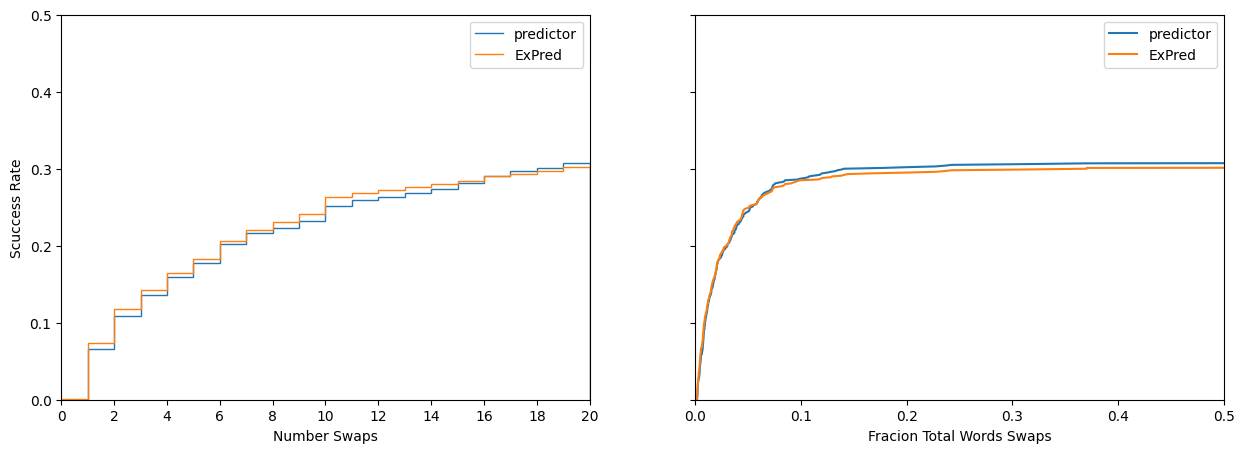

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.stairs(np.cumsum(cls_counts[1:]), bins[1:], label = 'predictor')
ax1.stairs(np.cumsum(mtl_counts[1:]), bins[1:], label = 'ExPred')
ax1.legend()
ax1.set_xlim(0, 20)
ax1.set_xticks(np.arange(0,21, 2))
ax1.set_xlabel("Number Swaps")
ax1.set_ylim(0, .5)
ax1.set_ylabel("Scuccess Rate")
ax2.plot(sorted_cls_percent, np.arange(0, 1, 1/sorted_cls_percent.size), label = 'predictor')
ax2.plot(sorted_mtl_percent, np.arange(0, 1, 1/sorted_cls_percent.size), label = 'ExPred')
# ax.stairs(np.cumsum(sorted_cls_percent), np.arange(sorted_cls_percent.size), label = 'cls_counts')
# ax.stairs(np.cumsum(sorted_mtl_percent), np.arange(sorted_mtl_percent.size), label = 'mtl_counts')
ax2.legend()
ax2.set_xlim(0, .5)
ax2.set_xticks(np.arange(0, 0.6, 0.1))
# ax.set_xticks(np.arange(0,1, .05))
ax2.set_xlabel("Fracion Total Words Swaps")
fig.savefig('number_swaps_1000.pdf')

Text(0, 0.5, 'scuccess rate')

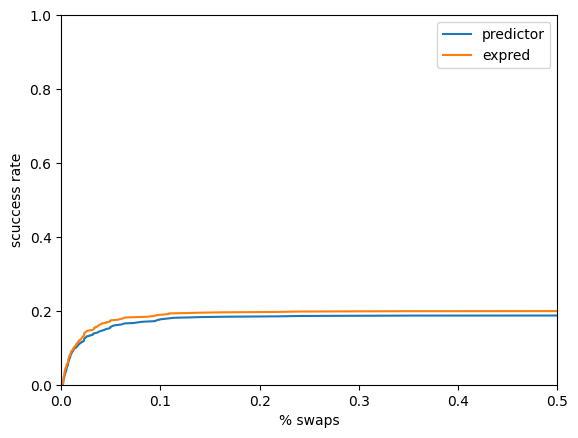

In [153]:
fig, ax = plt.subplots()
ax.plot(sorted_cls_percent, np.arange(0, 1, 1/sorted_cls_percent.size), label = 'predictor')
ax.plot(sorted_mtl_percent, np.arange(0, 1, 1/sorted_cls_percent.size), label = 'ExPred')
# ax.stairs(np.cumsum(sorted_cls_percent), np.arange(sorted_cls_percent.size), label = 'cls_counts')
#dd ax.stairs(np.cumsum(sorted_mtl_percent), np.arange(sorted_mtl_percent.size), label = 'mtl_counts')
ax.legend()
ax.set_xlim(0, .5)
# ax.set_xticks(np.arange(0,1, .05))
ax.set_xlabel("% swaps")
ax.set_ylim(0,.5)
ax.set_ylabel("scuccess rate")


In [ ]:
with open()

In [25]:
a = [[l[1] for l in list[1:]] for list in bbatch_swaps]

In [26]:
b = np.array([y for x in a for y in x])

In [204]:
# l =[i[0] for i in results_cand10 if len(i) != 0]
# v = np.array([a[0][1] for a in [i[0] for i in l if len(i[0]) != 0] for a[0] in a])
words_10, counts_10 = np.unique(b, return_counts=True)

In [27]:
words_1000, counts_1000 = np.unique(b, return_counts=True)

In [28]:
count_sort_ind = np.argsort(counts_1000)
sorted_words_1000 = words_1000[count_sort_ind[::-1]]
sorted_freq_1000 = counts_1000[count_sort_ind[::-1]]/len(words_1000)
sorted_counts_1000 = counts_1000[count_sort_ind[::-1]]

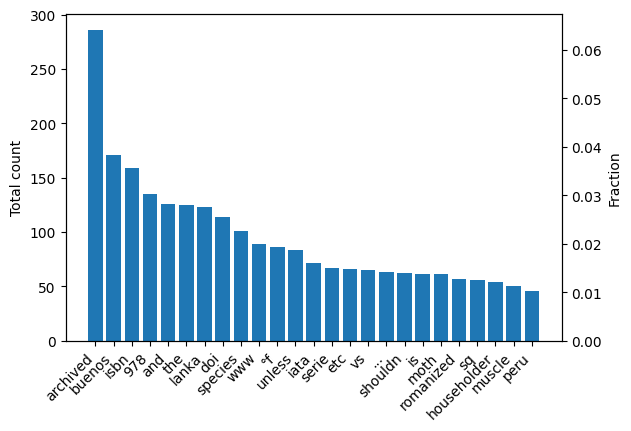

In [31]:
N = 25
fig, ax = plt.subplots()
labels = [tokenizer.convert_ids_to_tokens([words_1000[i]])[0] for i in count_sort_ind[:-(N + 1):-1]]
ax.bar(np.arange(N), sorted_counts_1000[:N])
ax.set_ylabel("Total count")
ax1 = ax.twinx()
ax1.set_ylim(0, sorted_freq_1000[0])
ax1.set_ylabel('Fraction')
ax.set_xticks(np.arange(N))
ax.set_xticklabels(labels)
fig.autofmt_xdate(rotation=45)
`s

In [142]:
sorted_freq_100

array([0.02327935, 0.02327935, 0.02226721, 0.02024291, 0.01619433,
       0.01518219, 0.01518219, 0.01417004, 0.01315789, 0.01315789,
       0.01214575, 0.01214575, 0.01214575, 0.0111336 , 0.0111336 ,
       0.0111336 , 0.01012146, 0.01012146, 0.01012146, 0.01012146,
       0.00910931, 0.00910931, 0.00910931, 0.00910931, 0.00809717,
       0.00809717, 0.00809717, 0.00809717, 0.00708502, 0.00708502,
       0.00708502, 0.00708502, 0.00708502, 0.00708502, 0.00708502,
       0.00708502, 0.00607287, 0.00607287, 0.00607287, 0.00607287,
       0.00506073, 0.00506073, 0.00506073, 0.00506073, 0.00506073,
       0.00506073, 0.00506073, 0.00506073, 0.00506073, 0.00506073,
       0.00506073, 0.00506073, 0.00506073, 0.00404858, 0.00404858,
       0.00404858, 0.00404858, 0.00404858, 0.00404858, 0.00404858,
       0.00404858, 0.00404858, 0.00404858, 0.00404858, 0.00404858,
       0.00404858, 0.00404858, 0.00404858, 0.00404858, 0.00404858,
       0.00404858, 0.00404858, 0.00404858, 0.00404858, 0.00303

In [145]:
tokenizer.convert_ids_to_tokens([words_100[493]])

['index']